# Check pair of neurons input-output relationships

This notebook contains:
<br><br>A) Individual synaptic counts distributions
<br>B) Pair-wise relationship

In [1]:
import os
import pandas as pd
import numpy as np
from fafbseg import flywire
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\smolina\Anaconda3\envs\EM\lib\site-packages\blessed\terminal.py:186: UserWarning: Failed to setupterm(kind='xterm-color'): Could not find terminal xterm-color
  warnings.warn(msg)


In [2]:
# Choose path and file
dataPath = r'D:\Connectomics-Data\FlyWire\Txts\cell_type_proofread'
fileDate = '20230920'
pre_neuron_type = 'LC14_L'
post_neuron_type = 'LC10_R'

pre_fileName = f'root_ids_{pre_neuron_type}_{fileDate}.txt'
post_fileName = f'root_ids_{post_neuron_type}_{fileDate}.txt'
pre_filePath = os.path.join(dataPath,pre_fileName)
post_filePath = os.path.join(dataPath,post_fileName)
pre_ids_df = pd.read_csv(pre_filePath, sep = ",")
post_ids_df = pd.read_csv(post_filePath, sep = ",")

pre_ids = pre_ids_df.columns.tolist()
post_ids = post_ids_df.columns.tolist()


In [3]:
# Update all ids
#Presynaptic cell ids
update_df = flywire.update_ids(pre_ids, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
up_to_date_pre_ids = update_df['new_id'].tolist()

#Postsynaptic cell ids
update_df = flywire.update_ids(post_ids, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
up_to_date_post_ids = update_df['new_id'].tolist()

Updating:   0%|          | 0/26 [00:00<?, ?it/s]

Updating:   0%|          | 0/352 [00:00<?, ?it/s]

In [4]:
# Getting inputs

# Fetch the neuron's inputs
post_inputs = flywire.synapses.fetch_synapses(up_to_date_post_ids, pre=False, post=True, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True,mat= "live")
# Fetch the neuron's inputs
pre_inputs = flywire.synapses.fetch_synapses(up_to_date_pre_ids, pre=False, post=True, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True,mat= "live")
# Getting outputs

# Fetch the neuron's outputs
post_outputs = flywire.synapses.fetch_synapses(up_to_date_post_ids, pre= True, post=False, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True,mat= "live")

# Fetch the neuron's outputs
pre_outputs = flywire.synapses.fetch_synapses(up_to_date_pre_ids, pre= True, post=False, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True,mat= "live")

Fetching synapses:   0%|          | 0/12 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/12 [00:00<?, ?it/s]

## A) Individual synaptic counts distributions

In [5]:
# For the defined postsynaptic partner
## Inputs
#Geeting all input counts for each presynaptic neuron id
post_inputs_counts = post_inputs.groupby(['post', 'pre'])['pre'].count().reset_index(name='pre_syn_count')

## Outputs
#Geeting all output counts for each presynaptic neuron id
post_outputs_counts = post_outputs.groupby(['post', 'pre'])['post'].count().reset_index(name='post_syn_count')



In [6]:
# For the defined presynaptic partner

## Inputs
#Geeting all input counts for each presynaptic neuron id
pre_inputs_counts = pre_inputs.groupby(['post', 'pre'])['pre'].count().reset_index(name='pre_syn_count')

## Outputs
#Geeting all output counts for each presynaptic neuron id
pre_outputs_counts = pre_outputs.groupby(['post', 'pre'])['post'].count().reset_index(name='post_syn_count')

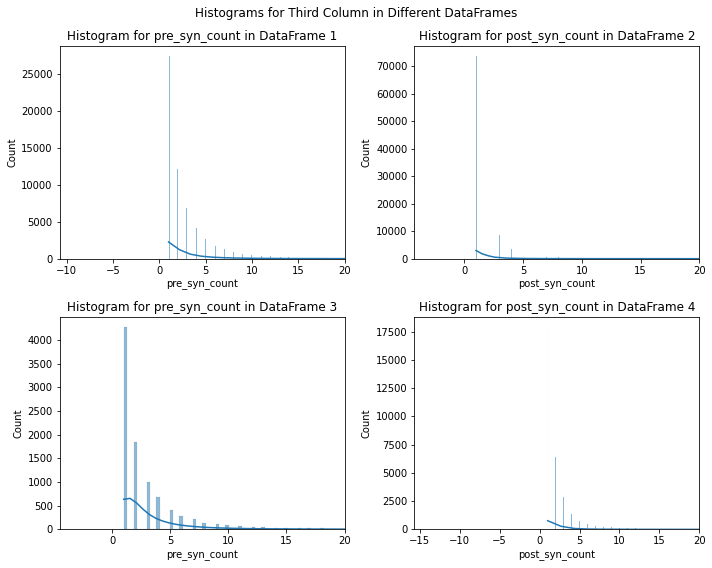

In [10]:
# Brief visualization

# List of data frames
data_frames = [post_inputs_counts, post_outputs_counts, pre_inputs_counts, pre_outputs_counts]

# List of data frames and their names
data_frames = {'DataFrame 1': post_inputs_counts, 'DataFrame 2': post_outputs_counts, 'DataFrame 3': pre_inputs_counts, 'DataFrame 4': pre_outputs_counts}

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
fig.suptitle('Histograms for Third Column in Different DataFrames')

# Set the absolute threshold for the maximum x-axis value
x_axis_threshold = 20  # Replace with your desired threshold

# Plot histograms in each subplot
for ax, (name, df) in zip(axes.flatten(), data_frames.items()):
    column_name = df.columns[2]  # Assuming the third column is always at index 2
    sns.histplot(data=df, x=column_name, ax=ax, kde=True)
    
    # Set the x-axis limit
    ax.set_xlim(right=x_axis_threshold)
    
    ax.set_title(f'Histogram for {column_name} in {name}')
    ax.set_xlabel(column_name)

# Adjust layout
plt.tight_layout()
plt.show()

## B) Pair-wise relationship

In [42]:
# Quick visualization of the weight of our presynaptic partner of interest as input of our postsynaptoc cell of interest

#Geeting all input counts for each presynaptic neuron id
post_inputs_counts = post_inputs.groupby(['post', 'pre'])['pre'].count().reset_index(name='pre_syn_count')

#Initializing variables
rel_neuron_type_weight = []
rel_neuron_weight = []
neuron_weight_post_ls = []
neuron_weight_pre_ls = []
#Looping to get the neuron and neuron type weigths to each postsynaptic partner
for _post in list(set(post_inputs_counts['post'].tolist())):
    curr_df = post_inputs_counts[post_inputs_counts['post'] == _post].copy()
    curr_total_syn_count = curr_df['pre_syn_count'].sum()
    curr_pre_type_df = curr_df[curr_df['pre'].isin(up_to_date_pre_ids)].copy()
    # Weitgh for all cell of the same type
    curr_rel_neuron_type_weight = curr_pre_type_df['pre_syn_count'].sum()/curr_total_syn_count
    rel_neuron_type_weight.append(curr_rel_neuron_type_weight)
    # Weitgh for individual cell of the same type
    if len(curr_pre_type_df['pre']) == 0:
        rel_neuron_weight.append(0.0)
        neuron_weight_post_ls.append(_post) # tracking the postsynaptic neuron ids
        neuron_weight_pre_ls.append('-') # tracking the presynaptic neuron ids
    else:
        for _pre in list(set(curr_pre_type_df['pre'].tolist())):
            neuron_weight_post_ls.append(_post) # tracking the postsynaptic neuron ids
            neuron_weight_pre_ls.append(_pre) # tracking the presynaptic neuron ids
            curr_rel_neuron_weight = curr_pre_type_df[curr_pre_type_df['pre'] == _pre]['pre_syn_count'].sum() / curr_total_syn_count
            rel_neuron_weight.append(curr_rel_neuron_weight)

#Summary data frames
neuron_weight_df = pd.DataFrame()
neuron_weight_df['rel_weight'] = rel_neuron_weight
neuron_weight_df['post'] = neuron_weight_post_ls
neuron_weight_df['pre'] = neuron_weight_pre_ls 
 


In [47]:
neuron_weight_df[neuron_weight_df['rel_weight'] == 0]['post'].tolist()

[720575940626972676,
 720575940623448078,
 720575940628822037,
 720575940643127319,
 720575940643207191,
 720575940645531671,
 720575940621203489,
 720575940644892708,
 720575940624787504,
 720575940614383682,
 720575940629076042,
 720575940621314124,
 720575940616712278,
 720575940626008153,
 720575940627804265,
 720575940619169901,
 720575940644393070,
 720575940622614655,
 720575940606099586,
 720575940606244994,
 720575940625465487,
 720575940623804560,
 720575940621365417,
 720575940636481716,
 720575940621050038,
 720575940619497665,
 720575940612499662,
 720575940629608663,
 720575940613085402,
 720575940613853411,
 720575940624050407,
 720575940627454193,
 720575940622917876,
 720575940628558074,
 720575940627933443,
 720575940626735364,
 720575940622475525,
 720575940622373127,
 720575940622950663,
 720575940630534418,
 720575940645441828,
 720575940624013606,
 720575940624029991,
 720575940621363532,
 720575940632103251,
 720575940626039129,
 720575940607510876,
 720575940616

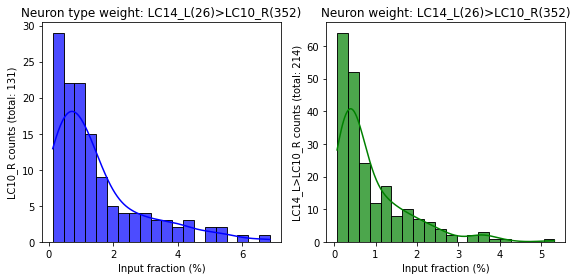

In [44]:
# Plotting 

#Filtering out 0 values
rel_neuron_type_weight = [x for x in rel_neuron_type_weight if x != 0]
rel_neuron_weight = [x for x in rel_neuron_weight if x != 0] 

# Calculate the percentage values
rel_neuron_type_weight_percent = [x * 100 for x in rel_neuron_type_weight] 
rel_neuron_weight_percent = [x * 100 for x in rel_neuron_weight] 

# Create subplots for each dimension using Seaborn
plt.figure(figsize=(12, 4))

plt.subplot(131)  # 1 row, 3 columns, 1st subplot
sns.histplot(rel_neuron_type_weight_percent, bins=20, color='blue', alpha=0.7, kde=True)
plt.title(f'Neuron type weight: {pre_neuron_type}({len(pre_ids)})>{post_neuron_type}({len(post_ids)})')
plt.xlabel('Input fraction (%)')  # Update the x-axis label
plt.ylabel(f'{post_neuron_type} counts (total: {len(rel_neuron_type_weight_percent)})')  # Update the x-axis label

plt.subplot(132)  # 1 row, 3 columns, 2nd subplot
sns.histplot(rel_neuron_weight_percent, bins=20, color='green', alpha=0.7, kde=True)
plt.title(f'Neuron weight: {pre_neuron_type}({len(pre_ids)})>{post_neuron_type}({len(post_ids)})')
plt.xlabel('Input fraction (%)')  # Update the x-axis label
plt.ylabel(f'{pre_neuron_type}>{post_neuron_type} counts (total: {len(rel_neuron_weight_percent)})')  # Update the x-axis label

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()